
# Introduction

This is my first stab at a Kaggle script. I have chosen to work with the Titanic dataset after spending some time poking around on the site and looking at other scripts made by other Kagglers for inspiration. I will also focus on doing some illustrative data visualizations along the way. I'll then use `randomForest` to create a model predicting survival on the Titanic. I am new to machine learning and hoping to learn a lot, so feedback is very welcome!

There are three parts to my script as follows:

* Feature engineering
* Missing value imputation
* Prediction!

## Load and check data



In [3]:
# Load packages
library('ggplot2') # visualization
library('ggthemes') # visualization
library('scales') # visualization
library('dplyr') # data manipulation
library('mice') # imputation
library('randomForest') # classification algorithm

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin




Now that our packages are loaded, let's read in and take a peek at the data.



In [8]:
train <- read.csv('./input/train.csv', stringsAsFactors = F)
test  <- read.csv('./input/test.csv', stringsAsFactors = F)

full  <- bind_rows(train, test) # bind training & test data

# check data
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...



We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:

Variable Name | Description
--------------|-------------
Survived      | Survived (1) or died (0)
Pclass        | Passenger's class
Name          | Passenger's name
Sex           | Passenger's sex
Age           | Passenger's age
SibSp         | Number of siblings/spouses aboard
Parch         | Number of parents/children aboard
Ticket        | Ticket number
Fare          | Fare
Cabin         | Cabin
Embarked      | Port of embarkation


# Feature Engineering
## What's in a name?

The first variable which catches my attention is **passenger name** because we can break it down into additional meaningful variables which can feed predictions or be used in the creation of additional new variables. For instance, **passenger title** is contained within the passenger name variable and we can use **surname** to represent families. Let's do some **feature engineering**!



In [9]:
# Grab title from passenger names
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)

# Show title counts by sex
table(full$Sex, full$Title)

# Titles with very low cell counts to be combined to "rare" level
rare_title <- c('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don',
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')

# Also reassign mlle, ms, and mme accordingly
full$Title[full$Title == 'Mlle']        <- 'Miss'
full$Title[full$Title == 'Ms']          <- 'Miss'
full$Title[full$Title == 'Mme']         <- 'Mrs'
full$Title[full$Title %in% rare_title]  <- 'Rare Title'

# Show title counts by sex again
table(full$Sex, full$Title)

# Finally, grab surname from passenger name
full$Surname <- sapply(full$Name,
                      function(x) strsplit(x, split = '[,.]')[[1]][1])

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

        
         Master Miss  Mr Mrs Rare Title
  female      0  264   0 198          4
  male       61    0 757   0         25

In [10]:
cat(paste('We have <b>', nlevels(factor(full$Surname)), '</b> unique surnames. I would be interested to infer ethnicity based on surname --- another time.'))

We have <b> 875 </b> unique surnames. I would be interested to infer ethnicity based on surname --- another time.


## Do families sink or swim together?

Now that we've taken care of splitting passenger name into some new variables, we can take it a step further and make some new family variables. First we're going to make a **family size** variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents.



In [11]:
# Create a family size variable including the passenger themselves
full$Fsize <- full$SibSp + full$Parch + 1

# Create a family variable
full$Family <- paste(full$Surname, full$Fsize, sep='_')


What does our family size variable look like? To help us understand how it may relate to survival, let's plot it among the training data.



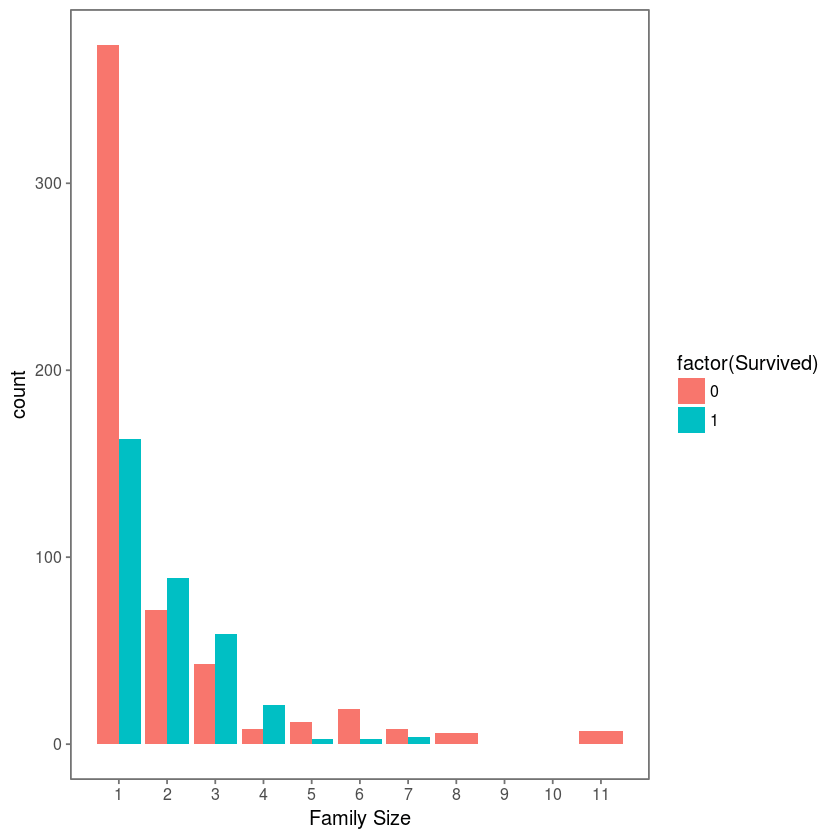

In [12]:
# Use ggplot2 to visualize the relationship between family size & survival
ggplot(full[1:891,], aes(x = Fsize, fill = factor(Survived))) +
  geom_bar(stat='count', position='dodge') +
  scale_x_continuous(breaks=c(1:11)) +
  labs(x = 'Family Size') +
  theme_few()


Ah hah. We can see that there's a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let's create a **discretized family size** variable.



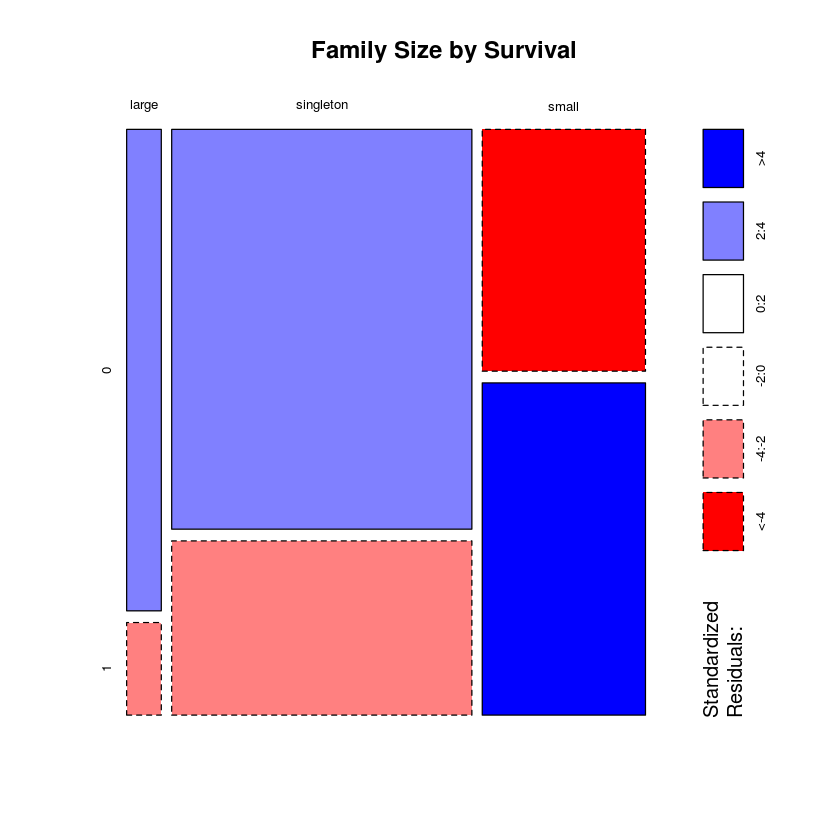

In [13]:
# Discretize family size
full$FsizeD[full$Fsize == 1] <- 'singleton'
full$FsizeD[full$Fsize < 5 & full$Fsize > 1] <- 'small'
full$FsizeD[full$Fsize > 4] <- 'large'

# Show family size by survival using a mosaic plot
mosaicplot(table(full$FsizeD, full$Survived), main='Family Size by Survival', shade=TRUE)


The mosaic plot shows that we preserve our rule that there's a survival penalty among singletons and large families, but a benefit for passengers in small families. I want to do something further with our age variable, but `r sum(is.na(full$Age))` rows have missing age values, so we will have to wait until after we address missingness.

## Treat a few more variables ...

What's left? There's probably some potentially useful information in the **passenger cabin** variable including about their **deck**. Let's take a look.



In [14]:
# This variable appears to have a lot of missing values
full$Cabin[1:28]

# The first character is the deck. For example:
strsplit(full$Cabin[2], NULL)[[1]]

# Create a Deck variable. Get passenger deck A - F:
full$Deck<-factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

[1] ""            "C85"         ""            "C123"        ""           
 [6] ""            "E46"         ""            ""            ""           
[11] "G6"          "C103"        ""            ""            ""           
[16] ""            ""            ""            ""            ""           
[21] ""            "D56"         ""            "A6"          ""           
[26] ""            ""            "C23 C25 C27"

[1] "C" "8" "5"


There's more that likely could be done here including looking into cabins with multiple rooms listed (e.g., row 28: "C23 C25 C27"), but given the sparseness of the column we'll stop here.

# Missingness

Now we're ready to start exploring missing data and rectifying it through imputation. There are a number of different ways we could go about doing this. Given the small size of the dataset, we probably should not opt for deleting either entire observations (rows) or variables (columns) containing missing values. We're left with the option of either replacing missing values with a sensible values given the distribution of the data, e.g., the mean, median or mode. Finally, we could go with prediction. We'll use both of the two latter methods and I'll rely on some data visualization to guide our decisions.

## Sensible value imputation



In [15]:
# Passengers 62 and 830 are missing Embarkment
full[c(62, 830), 'Embarked']

[1] "" ""

In [16]:
cat(paste('We will infer their values for **embarkment** based on present data that we can imagine may be relevant: **passenger class** and **fare**. We see that they paid<b> $', full[c(62, 830), 'Fare'][[1]][1], '</b>and<b> $', full[c(62, 830), 'Fare'][[1]][2], '</b>respectively and their classes are<b>', full[c(62, 830), 'Pclass'][[1]][1], '</b>and<b>', full[c(62, 830), 'Pclass'][[1]][2], '</b>. So from where did they embark?'))

We will infer their values for **embarkment** based on present data that we can imagine may be relevant: **passenger class** and **fare**. We see that they paid<b> $ 80 </b>and<b> $ NA </b>respectively and their classes are<b> 1 </b>and<b> NA </b>. So from where did they embark?

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

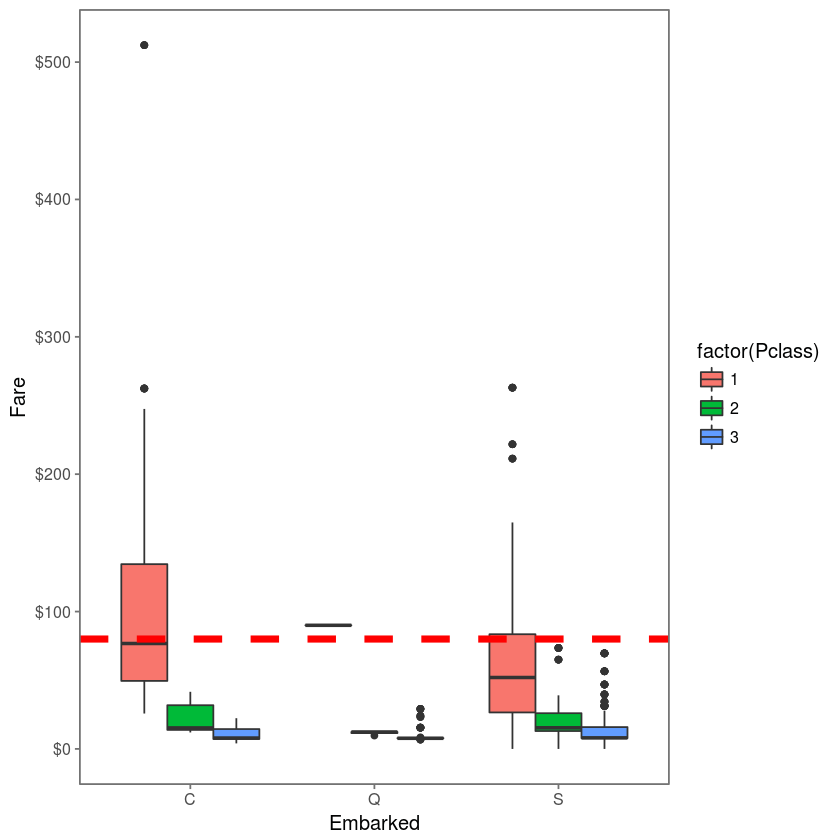

In [17]:
# Get rid of our missing passenger IDs
embark_fare <- full %>%
  filter(PassengerId != 62 & PassengerId != 830)

# Use ggplot2 to visualize embarkment, passenger class, & median fare
ggplot(embark_fare, aes(x = Embarked, y = Fare, fill = factor(Pclass))) +
  geom_boxplot() +
  geom_hline(aes(yintercept=80),
    colour='red', linetype='dashed', lwd=2) +
  scale_y_continuous(labels=dollar_format()) +
  theme_few()


Voilà! The median fare for a first class passenger departing from Charbourg ('C') coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with 'C'.



In [18]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full$Embarked[c(62, 830)] <- 'C'


We're close to fixing the handful of NA values here and there. Passenger on row 1044 has an NA Fare value.



In [19]:
# Show row 1044
full[1044, ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,Storey,1,Storey_1,singleton,NA



This is a third class passenger who departed from Southampton ('S'). Let's visualize Fares among all others sharing their class and embarkment (n = `r nrow(full[full$Pclass == '3' & full$Embarked == 'S', ]) - 1`).



Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

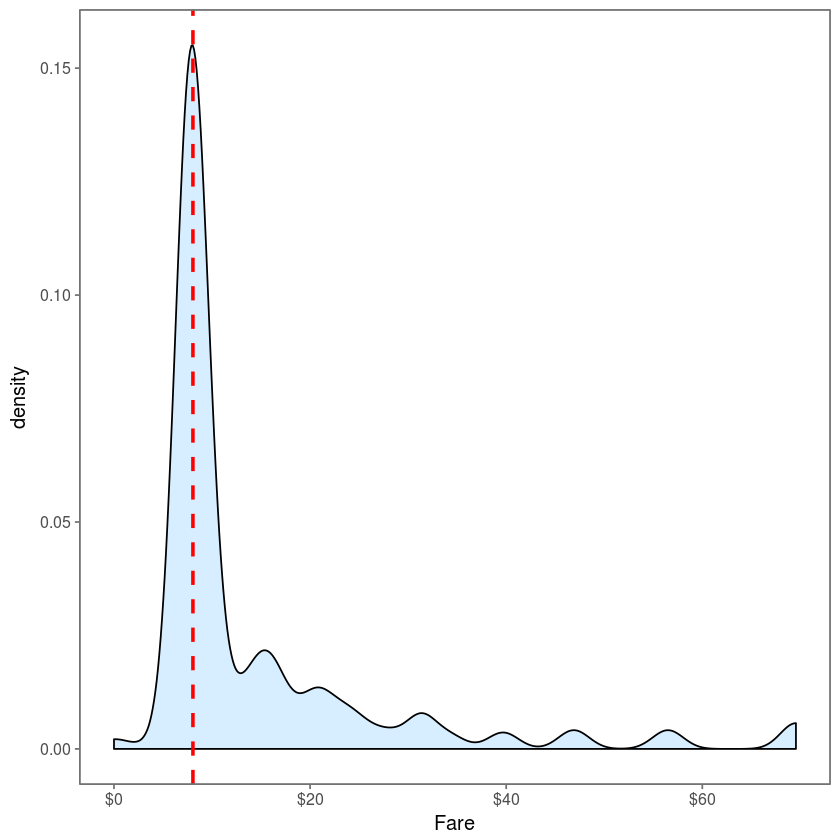

In [20]:
ggplot(full[full$Pclass == '3' & full$Embarked == 'S', ],
  aes(x = Fare)) +
  geom_density(fill = '#99d6ff', alpha=0.4) +
  geom_vline(aes(xintercept=median(Fare, na.rm=T)),
    colour='red', linetype='dashed', lwd=1) +
  scale_x_continuous(labels=dollar_format()) +
  theme_few()


From this visualization, it seems quite reasonable to replace the NA Fare value with median for their class and embarkment which is $`r  median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)`.



In [21]:
# Replace missing fare value with median fare for class/embarkment
full$Fare[1044] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)


## Predictive imputation

Finally, as we noted earlier, there are quite a few missing **Age** values in our data. We are going to get a bit more fancy in imputing missing age values. Why? Because we can. We will create a model predicting ages based on other variables.



In [22]:
# Show number of missing Age values
sum(is.na(full$Age))

[1] 263


We could definitely use `rpart` (recursive partitioning for regression) to predict missing ages, but I'm going to use the `mice` package for this task just for something different. You can read more about multiple imputation using chained equations in r [here](http://www.jstatsoft.org/article/view/v045i03/v45i03.pdf) (PDF). Since we haven't done it yet, I'll first factorize the factor variables and then perform mice imputation.



In [23]:
# Make variables factors into factors
factor_vars <- c('PassengerId','Pclass','Sex','Embarked',
                 'Title','Surname','Family','FsizeD')

full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))

# Set a random seed
set.seed(129)

# Perform mice imputation, excluding certain less-than-useful variables:
mice_mod <- mice(full[, !names(full) %in% c('PassengerId','Name','Ticket','Cabin','Family','Surname','Survived')], method='rf')

# Save the complete output
mice_output <- complete(mice_mod)


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck



Let's compare the results we get with the original distribution of passenger ages to ensure that nothing has gone completely awry.



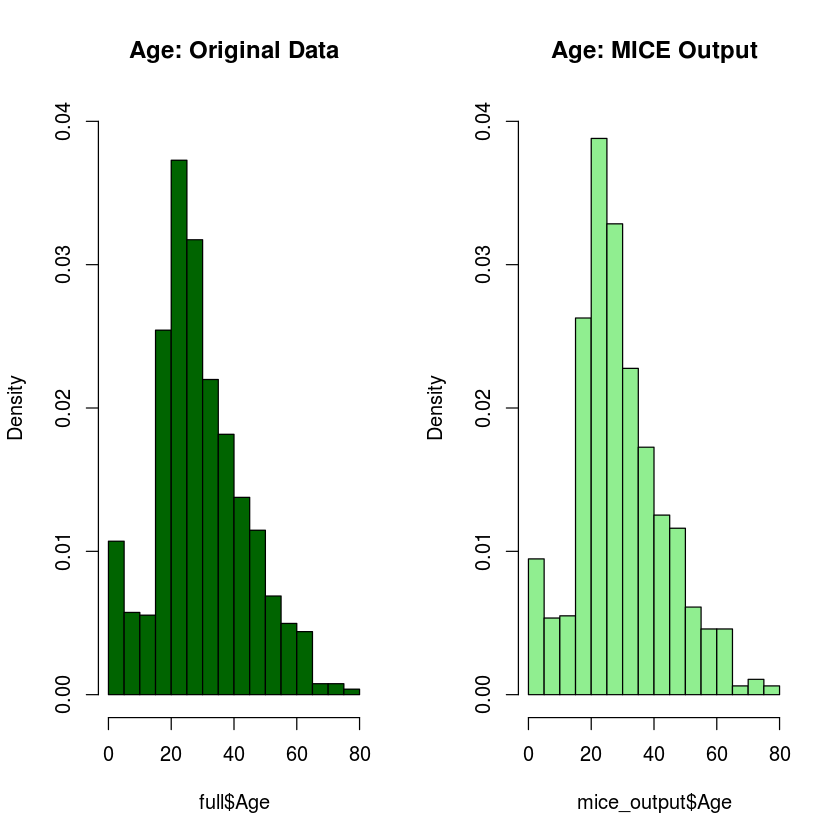

In [24]:
# Plot age distributions
par(mfrow=c(1,2))
hist(full$Age, freq=F, main='Age: Original Data',
  col='darkgreen', ylim=c(0,0.04))
hist(mice_output$Age, freq=F, main='Age: MICE Output',
  col='lightgreen', ylim=c(0,0.04))


Things look good, so let's replace our age vector in the original data with the output from the `mice` model.



In [25]:
# Replace Age variable from the mice model.
full$Age <- mice_output$Age

# Show new number of missing Age values
sum(is.na(full$Age))

[1] 0


We've finished imputing values for all variables that we care about for now! Now that we have a complete Age variable, there are just a few finishing touches I'd like to make. We can use Age to do just a bit more feature engineering ...

## Feature Engineering: Round 2

Now that we know everyone's age, we can create a couple of new age-dependent variables: **Child** and **Mother**. A child will simply be someone under 18 years of age and a mother is a passenger who is 1) female, 2) is over 18, 3) has more than 0 children (no kidding!), and 4) does not have the title 'Miss'.



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


       
          0   1
  Adult 484 274
  Child  65  68

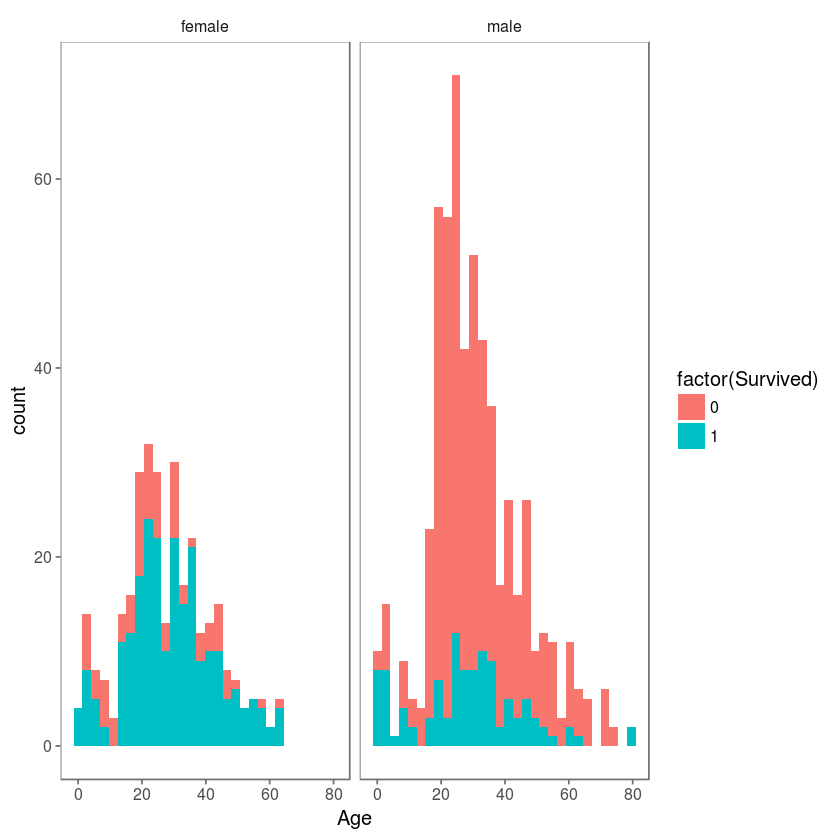

In [26]:
# First we'll look at the relationship between age & survival
ggplot(full[1:891,], aes(Age, fill = factor(Survived))) +
  geom_histogram() +
  # I include Sex since we know (a priori) it's a significant predictor
  facet_grid(.~Sex) +
  theme_few()

# Create the column child, and indicate whether child or adult
full$Child[full$Age < 18] <- 'Child'
full$Child[full$Age >= 18] <- 'Adult'

# Show counts
table(full$Child, full$Survived)


Looks like being a child doesn't hurt, but it's not going to necessarily save you either! We will finish off our feature engineering by creating the **Mother** variable. Maybe we can hope that mothers are more likely to have survived on the Titanic.



In [27]:
# Adding Mother variable
full$Mother <- 'Not Mother'
full$Mother[full$Sex == 'female' & full$Parch > 0 & full$Age > 18 & full$Title != 'Miss'] <- 'Mother'

# Show counts
table(full$Mother, full$Survived)

# Finish by factorizing our two new factor variables
full$Child  <- factor(full$Child)
full$Mother <- factor(full$Mother)

            
               0   1
  Mother      16  39
  Not Mother 533 303


All of the variables we care about should be taken care of and there should be no missing data. I'm going to double check just to be sure:



In [28]:
md.pattern(full)

Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Surname,⋯,Family,FsizeD,Child,Mother,Ticket,Survived,Deck,Name,Cabin,
150,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,0,0,2
61,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,1,0,0,3
54,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,1,1,0,0,3
511,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,0,0,0,3
30,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,0,1,0,0,4
235,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,0,0,0,4
176,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,1,0,0,0,4
92,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,0,0,0,0,5
,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,352,418,1014,1309,1309,4402



Wow! We have finally finished treating all of the relevant missing values in the Titanic dataset which has included some fancy imputation with `mice`. We have also successfully created several new variables which we hope will help us build a model which reliably predicts survival.


# Prediction

At last we're ready to predict who survives among passengers of the Titanic based on variables that we carefully curated and treated for missing values. For this, we will rely on the `randomForest` classification algorithm; we spent all that time on imputation, after all.

## Split into training & test sets

Our first step is to split the data back into the original test and training sets.



In [29]:
# Split the data back into a train set and a test set
train <- full[1:891,]
test <- full[892:1309,]


## Building the model

We then build our model using `randomForest` on the training set.



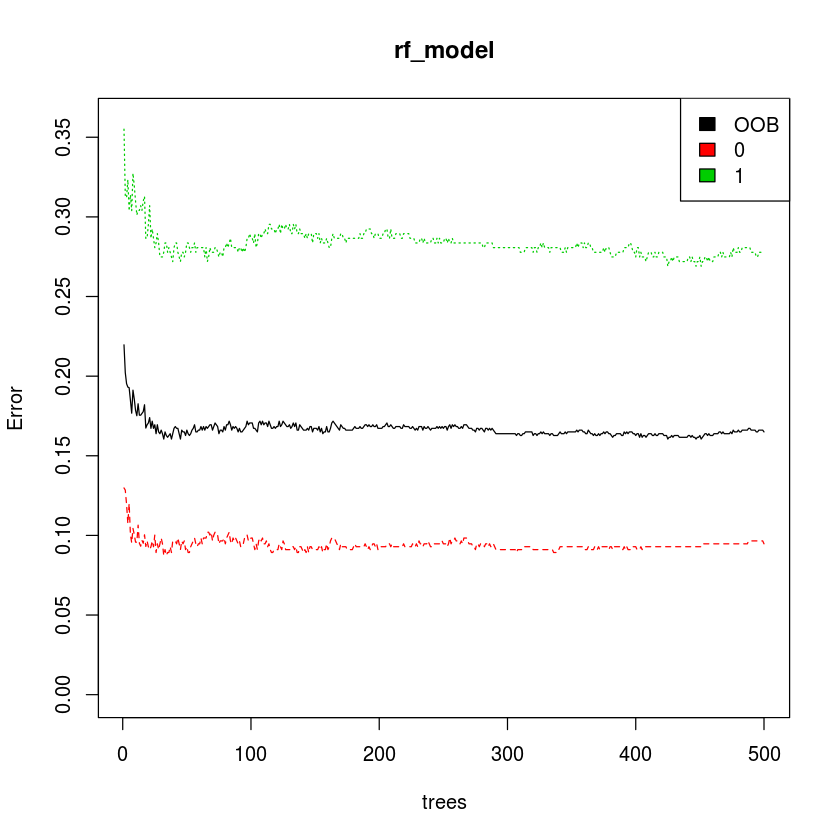

In [30]:
# Set a random seed
set.seed(754)

# Build the model (note: not all possible variables are used)
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch +
                                            Fare + Embarked + Title +
                                            FsizeD + Child + Mother,
                                            data = train)

# Show model error
plot(rf_model, ylim=c(0,0.36))
legend('topright', colnames(rf_model$err.rate), col=1:3, fill=1:3)


The black line shows the overall error rate which falls below 20%. The red and green lines show the error rate for 'died' and 'survived' respectively. We can see that right now we're much more successful predicting death than we are survival. What does that say about me, I wonder?

## Variable importance

Let's look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.



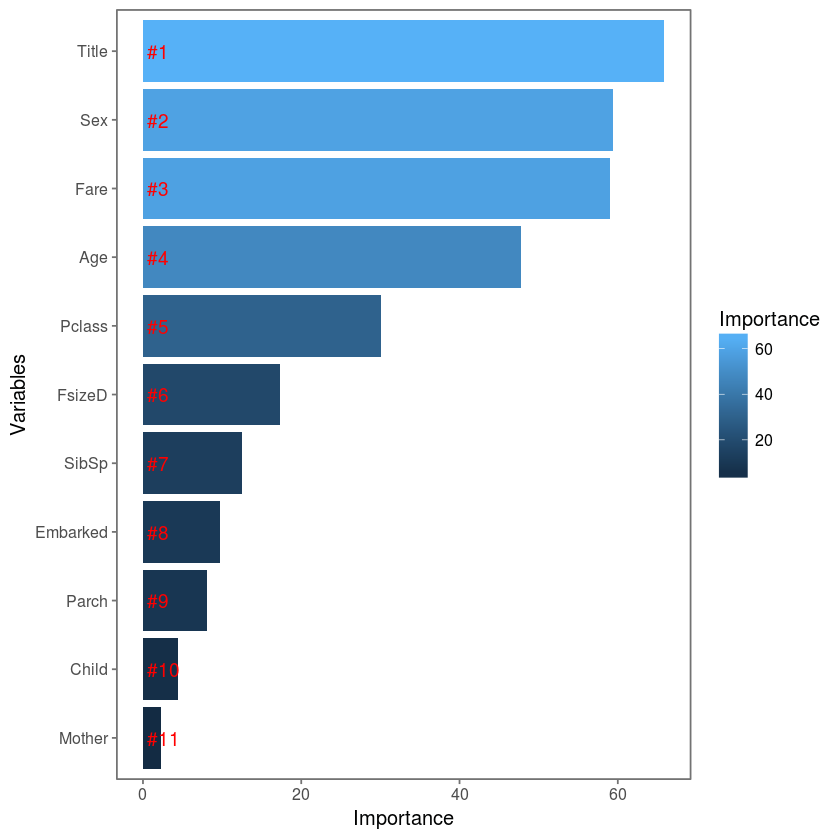

In [31]:
# Get importance
importance    <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance),
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))

# Create a rank variable based on importance
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

# Use ggplot2 to visualize the relative importance of variables
ggplot(rankImportance, aes(x = reorder(Variables, Importance),
    y = Importance, fill = Importance)) +
  geom_bar(stat='identity') +
  geom_text(aes(x = Variables, y = 0.5, label = Rank),
    hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() +
  theme_few()


Whoa, glad we made our title variable! It has the highest relative importance out of all of our predictor variables. I think I'm most surprised to see that passenger class fell to `r rankImportance[rankImportance$Variable == 'Pclass', ]$Rank`, but maybe that's just bias coming from watching the movie Titanic too many times as a kid.

## Prediction!

We're ready for the final step --- making our prediction! When we finish here, we could iterate through the preceding steps making tweaks as we go or fit the data using different models or use different combinations of variables to achieve better predictions. But this is a good starting (and stopping) point for me now.



In [32]:
# Predict using the test set
prediction <- predict(rf_model, test)

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution <- data.frame(PassengerID = test$PassengerId, Survived = prediction)

# Write the solution to file
write.csv(solution, file = 'rf_mod_Solution.csv', row.names = F)


# Conclusion

Thank you for taking the time to read through my first exploration of a Kaggle dataset. I look forward to doing more. Again, this newbie welcomes comments and suggestions!

---
